# [Atividade Computacional 2](http://mtm.ufsc.br/~douglas/2025.1/MTM410024_MTM3523/Atividade2.pdf)

Em muitas funções, utilizei a macro `@views`, que faz com que as operações não
criem cópias de vetores para os cálculos, otimizando a performance, conforme a
sessão [Performance tips](https://docs.julialang.org/en/v1/manual/performance-tips/index.html#man-performance-views) do Manual do `julia`.

In [1]:
using LinearAlgebra

## Questão 1

In [2]:
@views function substituicaoReversa(U,b)
  m,n = size(U)
  nb = length(b)
  if m != n
    throw( DimensionMismatch("Matriz U não é quadrada ($m x $n)"))
  end
  if nb != n
    throw(DimensionMismatch("Lado direito não tem o tamanho correto: U($m x $n), b($nb)"))
  end
  x = zeros(n)
  x[n] = b[n]/U[n,n]
  for i = n-1:-1:1
    x[i] = (b[i] - U[i,i:end]'*x[i:end])/U[i,i]
  end
  x
end


substituicaoReversa (generic function with 1 method)

In [3]:
A = [2 3 4; 0 5 6; 0 0 7];
x = [ 1, 0, 0];

substituicaoReversa(A,A*x)

3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [4]:

@views function substituicaoDireta(L,b)
  m, n = size(L)
  nb = length(b)
  if m != n
    throw( DimensionMismatch("Matriz L não é quadrada ($m x $n)"))
  end
  if nb != n
    throw(DimensionMismatch("Lado direito não tem o tamanho correto: L($m x $n), b($nb)"))
  end
  x = zeros(n)
  x[1] = b[1]/L[1,1]
  for i = 2:n
    x[i] = (b[i] - L[i,1:i]'*x[1:i])/L[i,i]
  end
  x
end


substituicaoDireta (generic function with 1 method)

In [5]:
A = [2 0 0; 3 5 0; 7 9 11];
x = [ 1, 0, 0];

substituicaoDireta(A,A*x)

3-element Vector{Float64}:
 1.0
 0.0
 0.0

## Questão 2

In [6]:
function matrizBandaNaUnha(n)
  # Código que tinha feito antes da aula que aprendemos sobre o SparseArrays
  #A = zeros(n,n)
  A = 4.0*I(n)+zeros(n,n)
  for i = 1:n
    for j = max(1,i-2):min(i+2,n)
      if i == j
        #A[i,j] = 4
      else
        A[i,j] = -1.0
      end
    end
  end
  A
end

matrizBandaNaUnha (generic function with 1 method)

In [7]:
using SparseArrays
function matrizBanda(n)
  A = spdiagm( 0 => 4*ones(n), 1=> -1*ones(n-1), -1 => -1*ones(n-1), 2 => -1*ones(n-2), -2 => -1*ones(n-2))
  AA = convert(Array{Float64}, A)
  return AA
end

matrizBanda (generic function with 1 method)

In [8]:
matrizBanda(10)

10×10 Matrix{Float64}:
  4.0  -1.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   4.0  -1.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0  -1.0   4.0  -1.0  -1.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0  -1.0   4.0  -1.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0  -1.0   4.0  -1.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0  -1.0   4.0  -1.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0  -1.0   4.0  -1.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0  -1.0   4.0  -1.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.0  -1.0   4.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0  -1.0   4.0

### Fatoração LU

In [9]:
# Métodos em julia que alteram seus argumentos inloco
# usam ! para alertar o usuário
"""
    mu = pivotar!(A,j)

Pivota a matriz A na coluna j e retorna um vetor mu de tamanho n,
que é a j-ésima coluna da matriz L da fatoração LU.
"""
@views function pivotar!(A,j)
 # Pivota a matriz A na coluna j
  m, n = size(A)
  mu = zeros(n)
  mu[j] = 1
  for l = j+1:n # l é o índice da linha
      mu[l] = A[l,j]/A[j,j]
      # Linha l é igual a linha l menos pivô*linha j
      A[l,:] .-=  mu[l]*A[j,:]
  end
  # alteramos a A diretamente e retornamos mu
  return mu
end;

"""
  Calcula a fatoração LU da matriz A, sem pivotamento nem troca de linhas.
"""
@views function flu(A)
  m, n = size(A)
  U = copy(A) # vamos criar uma cópida de A que será pivotada
  L =  zeros(n,n)
  for k = 1:n
    mu = pivotar!(U,k)
    L[:,k] .= mu
  end
  return L, U
end;

Vamos testar o meu código com o da biblioteca padrão.

In [40]:
# Testando o código
n = 10
A = 4*I(n) + rand(n,n) # tentei criar uma matriz com os maiores pivôs na diagonal
@time L, U = flu(A);
@time F = lu(A);

  0.000038 seconds (60 allocations: 9.578 KiB)
  0.000029 seconds (3 allocations: 1.047 KiB)


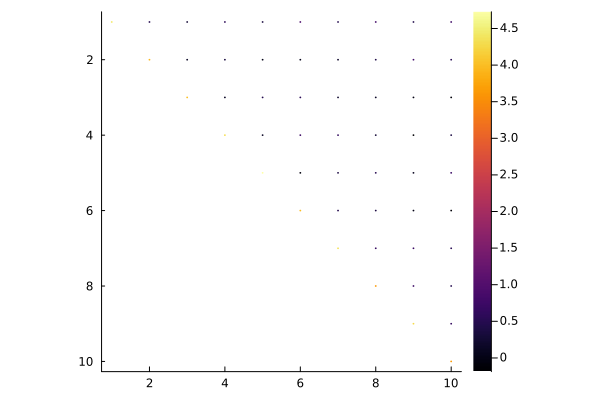

In [45]:
spy(F.U)

In [44]:
# Meu método: A = LU
# Método dos cara: PA = LU
norm(L*triu(U)-A), norm(F.L*F.U-F.P*A)

(1.6077283907308813e-15, 3.6088919696935627e-16)

Resultado: perdi feio no tempo, alocação de memória e precisão.

### Fatoração Cholesky

In [12]:
@views function fchol(A)
  m, n = size(A)
  G = zeros(n,n)
  for i=1:n
    parcelas = [G[k,i]^2 for k=1:i-1]
    G[i,i] = sqrt(A[i,i] - sum(parcelas))
    for j=i+1:n
      parcelas = [ G[k,i]*G[k,j] for k=1:i-1 ]
      G[i,j] = (A[i,j] - sum(parcelas))/G[i,i]
    end
  end
  # a G calculada assim é a transposta da matriz que queremos
  return G'
end;

Testando meu código

In [13]:
# Testando Cholesky
n = 400
A = spdiagm( 0 => 4*ones(n), 1=> ones(n-1), -1 => ones(n-1))
A = convert(Array{Float64}, A);
@time L = fchol(A)
@time F = cholesky(A)
norm(L*L'-A), norm(F.L*F.L'-A)

  0.498635 seconds (188.88 k allocations: 97.824 MiB, 51.63% gc time, 34.63% compilation time)
  0.079122 seconds (48.28 k allocations: 4.479 MiB, 96.78% compilation time)


(3.1244445429724018e-15, 3.1244445429724018e-15)

Igualei a precisão e só perdi em tempo e alocação, menos feio dessa vez.

### Resolvendo os sistemas

#### $n=10$

In [14]:
n = 10
A = matrizBanda(n)
@time L, U = flu(A);
@time G = fchol(A);

  0.000029 seconds (60 allocations: 9.578 KiB)
  0.000023 seconds (57 allocations: 5.422 KiB)


In [15]:
b = A[:,n]

@time begin
y = substituicaoDireta(L,b)
xLU = substituicaoReversa(U,y)
end;

@time begin
y = substituicaoDireta(G,b)
xC = substituicaoReversa(G',y)
end;
norm(A*xLU-b), norm(A*xC-b)

  0.117749 seconds (139.39 k allocations: 9.220 MiB, 99.93% compilation time)
  0.106034 seconds (123.42 k allocations: 8.388 MiB, 99.94% compilation time)


(0.0, 0.0)

#### $n=100$

In [19]:
n = 100
A = matrizBanda(n)
@time L, U = flu(A);
@time G = fchol(A);

  0.001224 seconds (5.06 k allocations: 4.468 MiB)
  0.011162 seconds (5.05 k allocations: 1.671 MiB, 93.63% gc time)


In [20]:
b = A[:,n]

@time begin
y = substituicaoDireta(L,b)
xLU = substituicaoReversa(U,y)
end;

@time begin
y = substituicaoDireta(G,b)
xC = substituicaoReversa(G',y)
end;
norm(A*xLU-b), norm(A*xC-b)

  0.000096 seconds (2 allocations: 1.750 KiB)
  0.000044 seconds (2 allocations: 1.750 KiB)


(0.0, 0.0)

#### $n=200$

In [21]:
n = 200
A = matrizBanda(n)
@time L, U = flu(A);
@time G = fchol(A);

  0.010471 seconds (20.11 k allocations: 35.268 MiB)
  0.008727 seconds (20.10 k allocations: 11.992 MiB, 60.39% gc time)


In [22]:
b = A[:,n]

@time begin
y = substituicaoDireta(L,b)
xLU = substituicaoReversa(U,y)
end;

@time begin
y = substituicaoDireta(G,b)
xC = substituicaoReversa(G',y)
end;
norm(A*xLU-b), norm(A*xC-b)

  0.000192 seconds (2 allocations: 3.531 KiB)
  0.000121 seconds (2 allocations: 3.531 KiB)


(0.0, 4.577566798522237e-16)

#### $n=400$

In [23]:
n = 400
A = matrizBanda(n)
@time L, U = flu(A);
@time G = fchol(A);

  0.214068 seconds (80.21 k allocations: 256.983 MiB, 9.35% gc time)
  0.043624 seconds (80.20 k allocations: 90.511 MiB, 10.61% gc time)


In [24]:
b = A[:,n]

@time begin
y = substituicaoDireta(L,b)
xLU = substituicaoReversa(U,y)
end;

@time begin
y = substituicaoDireta(G,b)
xC = substituicaoReversa(G',y)
end;
norm(A*xLU-b), norm(A*xC-b)

  0.000478 seconds (2 allocations: 6.500 KiB)
  0.000378 seconds (2 allocations: 6.500 KiB)


(0.0, 8.881784197001252e-16)

Note que a fatoração Cholesky é sempre mais rápida, mas a partir de um certo $n$ começa a apresentar resultados mais imprecisos.

## Questão 3

Analisar a esparsidade

In [37]:
using Plots

In [ ]:
U[100:120,2:20]

21×19 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  -3.23996e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.20805e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.17677e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.14609e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.116e-17    0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  -3.08648e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.05752e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.02909e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -3.00118e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -2.97379e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  -2.94689e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  -2.92047e-17  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0 

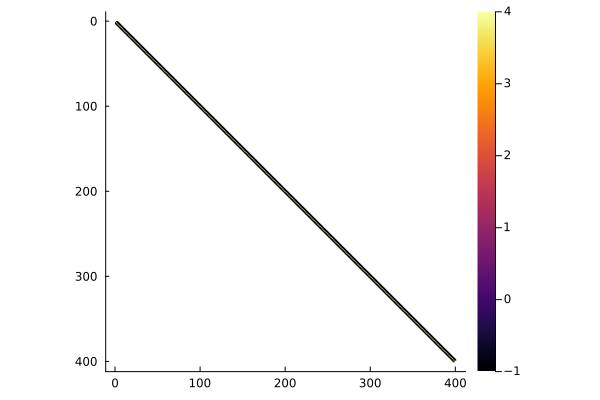

In [ ]:
spy(A)

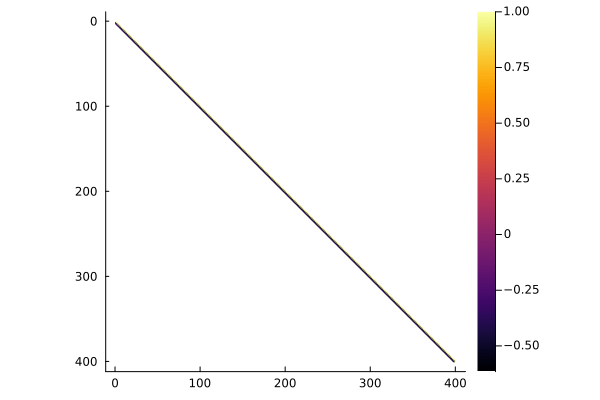

In [ ]:
spy(L)

In [ ]:
spy(U)

Output hidden; open in https://colab.research.google.com to view.

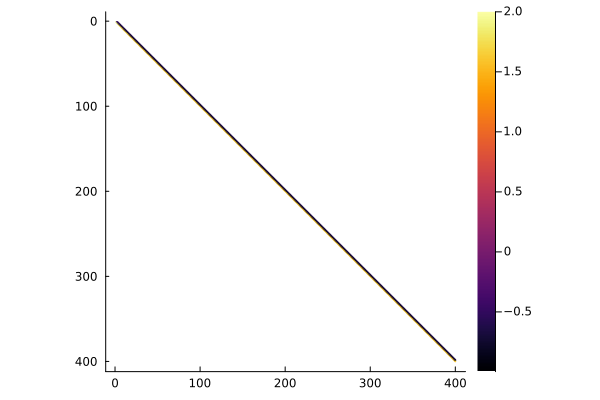

In [ ]:
spy(G)

A esparsidade foi preservada tanto na $G$ quanto na $L$, mas o ruído se propagou na matriz $U$, quebrando sua esparsidade.

## Questão 4

Vou usar a função `sparse` para melhor mostrar os elementos não nulos das matrizes.


In [28]:
A = zeros(6,6)
for i = 1:6
  A[i,i] = 1.0
end
A[1,2:6] .= 0.1
A[2:6,1] .= 0.1;
sparse(A)

6×6 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
 1.0  0.1  0.1  0.1  0.1  0.1
 0.1  1.0   ⋅    ⋅    ⋅    ⋅ 
 0.1   ⋅   1.0   ⋅    ⋅    ⋅ 
 0.1   ⋅    ⋅   1.0   ⋅    ⋅ 
 0.1   ⋅    ⋅    ⋅   1.0   ⋅ 
 0.1   ⋅    ⋅    ⋅    ⋅   1.0

In [29]:
G = fchol(A)
sparse(G)

6×6 SparseMatrixCSC{Float64, Int64} with 21 stored entries:
 1.0    ⋅           ⋅           ⋅           ⋅          ⋅ 
 0.1   0.994987     ⋅           ⋅           ⋅          ⋅ 
 0.1  -0.0100504   0.994937     ⋅           ⋅          ⋅ 
 0.1  -0.0100504  -0.0101524   0.994885     ⋅          ⋅ 
 0.1  -0.0100504  -0.0101524  -0.0102565   0.994832    ⋅ 
 0.1  -0.0100504  -0.0101524  -0.0102565  -0.0103628  0.994778

In [30]:
norm(G*G'-A)

2.2206441449836374e-16

Veja que $G$ é uma matriz triangular cheia, perdendo toda a esparsidade.

In [31]:
# Com a dica dada em sala, suspeitei que a matriz P
# seria uma identidade na antidiagonal
P = zeros(6,6)
for i=1:6
  P[i,6-i+1] = 1
end
sparse(P)

6×6 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 

In [32]:
sparse(P*A*P')

6×6 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅   0.1
  ⋅   1.0   ⋅    ⋅    ⋅   0.1
  ⋅    ⋅   1.0   ⋅    ⋅   0.1
  ⋅    ⋅    ⋅   1.0   ⋅   0.1
  ⋅    ⋅    ⋅    ⋅   1.0  0.1
 0.1  0.1  0.1  0.1  0.1  1.0

In [33]:
C = fchol(P*A*P')
sparse(C)

6×6 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
 0.1  0.1  0.1  0.1  0.1  0.974679

In [34]:
norm(C*C' - P*A*P')

1.1102230246251565e-16